In [23]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
from torch.optim import NAdam, Adam, SGD
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score, explained_variance_score
from torchmetrics.regression import ExplainedVariance
import xgboost as xgb
from collections import OrderedDict



In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)


### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


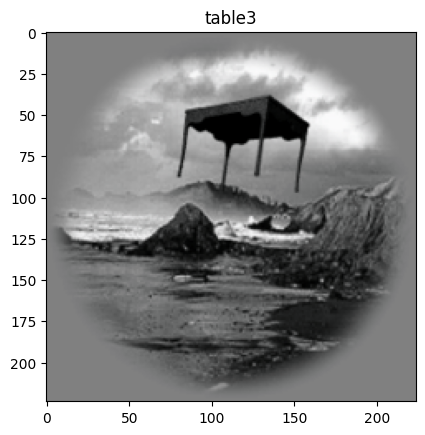

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

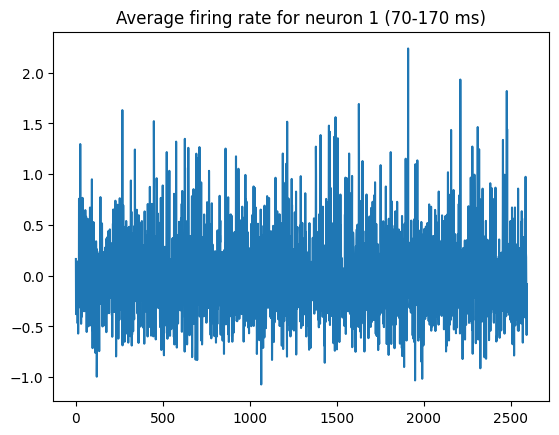

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

# NEW TRAINING

In [7]:
def train_model(model,scheduler, train_loader, validation_dataloader, criterion, optimizer, num_epochs=10, device='cuda', max_patience=20):
    model = model.to(device)

    model.train()

    best_loss = 1e3
    patience = 0
    with tqdm(total=num_epochs, desc=f"Epoch 0/{num_epochs}") as pbar:

        for epoch in tqdm(range(num_epochs), desc=f"Training epochs"):
            running_loss = 0.0
            val_loss = 0.0
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()
                if not scheduler is None:
                    scheduler.step()

                running_loss += loss.item() * inputs.size(0)

            for inputs, labels in validation_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            val_loss = val_loss / len(validation_dataloader.dataset)
            if val_loss<best_loss:
                best_model_state_dict = {k:v.detach().to('cpu') for k, v in model.state_dict().items()}
                best_model_state_dict = OrderedDict(best_model_state_dict)
                best_loss = val_loss
                patience = 0
            else:
                patience+=1

            if patience == max_patience:
                break
            pbar.set_description(f"Epoch {epoch + 1}/{num_epochs}")
            pbar.set_postfix(train_loss=epoch_loss , val_loss=val_loss, patience=patience)
            pbar.update(1)
            pbar.refresh() 
            
    model.load_state_dict(best_model_state_dict)

    return model



In [8]:
def evaluate(model, validation_dataloader, device='cuda'):
    model.to(device)
    predictions = []
    true_labels = []
    for inputs, labels in validation_dataloader:
        inputs = inputs.to(device)

        predictions.append(model(inputs).detach().cpu())
        true_labels.append(labels)
    y_pred = torch.cat(predictions, dim=0).numpy()
    y_true = torch.cat(true_labels, dim=0).numpy()
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    explained_variance = explained_variance_score(y_true, y_pred)
    print(f"RMSE: {rmse}")
    print("R2:", r2)
    print("Explained Variance:", explained_variance)

In [9]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [10]:
# Define your custom layer
class CustomLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        # Add any other layers or modifications as needed
        nn.init.kaiming_normal_(self.fc.weight)
        nn.init.zeros_(self.fc.bias) 

    def forward(self, x):
        x = self.fc(x)
        # Add any other operations in the forward pass
        return x

# Task driven approach

## Densenet 169

In [24]:
import torch
from torchvision.models import densenet169

densenet = densenet169(pretrained=True).cpu()

densenet.eval()

/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mloscratch/homes/reategui/conda/envs/nx/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Extraction of densenet layers

In [25]:
densenet_layers = {
    'conv0': densenet.features.conv0,
    'denseblock1': densenet.features.denseblock1,
    'denseblock2': densenet.features.denseblock2,
    'denseblock3': densenet.features.denseblock3,
    'denseblock4': densenet.features.denseblock4,
    'transition1': densenet.features.transition1,
    'transition2': densenet.features.transition2,
    'transition3': densenet.features.transition3,
    'norm5': densenet.features.norm5,
}

In [135]:
densenet_shapes = {
    'conv0': 802816,
    'denseblock1': 802816,
    'denseblock2': 401408,
    'denseblock3': 250880,
    'denseblock4': 81536,
    'transition1': 100352,
    'transition2': 50176,
    'transition3': 31360,
    'norm5': 81536,
}

In [27]:
for stimulus, suffix, batch_size in zip ((stimulus_train, stimulus_val), ("train", "val"), (162,32)):
    folder = "densenet169/pretrained"
    activation_files = {name: np.memmap(f"{folder}/{name}_activations_{suffix}.npy" , dtype=np.float32, mode='w+', shape=(len(stimulus),densenet_shapes[name]))
                        for name in densenet_layers.keys()}

    def hook(name, idx):
        def hook(module, input, output):
            output = output.detach().cpu().reshape(batch_size, -1).numpy()
            activation_files[name][idx*batch_size:(idx+1)*batch_size,:] = output  
            activation_files[name].flush()
        return hook

    for key,layer in densenet_layers.items():

        for idx in tqdm(range(len(stimulus)//batch_size)):
            hook_handle = layer.register_forward_hook(hook(key,idx))
            batch = stimulus[idx*batch_size:(idx+1)*batch_size]
            _ = densenet(torch.tensor(batch))
            hook_handle.remove()

100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


In [28]:
device = "cuda"

Computing the pca using torch.low_rank implementation on cuda can lead to strong speed ups

In [29]:
num_components = 1000  
folder = "densenet169/pretrained"


for key,item in tqdm(densenet_shapes.items()):
    array = torch.tensor(np.memmap(f"{folder}/{key}_activations_train.npy" , mode='r',shape=(len(stimulus_train),item), dtype=np.float32), dtype=torch.float32).to(device)

    U, S, V = torch.pca_lowrank(array, q=num_components)
    array = torch.matmul(array, V).cpu().numpy()
    np.save(f"{folder}/{key}_{num_components}PCs_train.npy", array)

    array = torch.tensor(np.memmap(f"{folder}/{key}_activations_val.npy" , mode='r',shape=(len(stimulus_val),item), dtype=np.float32), dtype=torch.float32).to(device)
    array = torch.matmul(array, V).cpu().numpy()
    np.save(f"{folder}/{key}_{num_components}PCs_val.npy", array)

100%|██████████| 9/9 [00:35<00:00,  3.96s/it]


In [141]:
num_components = 1000

Loading saved pca activations

In [34]:
import numpy as np
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,MultiTaskLassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler

Scoring function

In [32]:
def analyze(folder, model_name, shapes):
    scores = {}

    for layer in list(shapes.keys())+["all"]:
        scores[layer] = {}
        if layer == "all":
            activations_train = np.concatenate([np.load(f"{folder}/{key}_{num_components}PCs_train.npy") for key in shapes.keys()], axis=1)
            activations_val = np.concatenate([np.load(f"{folder}/{key}_{num_components}PCs_val.npy") for key in shapes.keys()], axis=1)
        else:
            activations_train = np.load(f"{folder}/{layer}_{num_components}PCs_train.npy")
            activations_val = np.load(f"{folder}/{layer}_{num_components}PCs_val.npy")
        if model_name == "Linear":
            model = LinearRegression()
            model.fit(activations_train, spikes_train)
        elif model_name == "Ridge":
            alphas = np.logspace(-12, 12, 26)
            model = RidgeCV(alphas=alphas, store_cv_values=True)
            model.fit(activations_train, spikes_train)
        elif model_name == "xgb":
            model = xgb.XGBRegressor(objective ='reg:squarederror', max_depth = 5, n_estimators = 50, n_jobs=4)
            model.fit(activations_train,spikes_train)
        else: 
            NotImplementedError
        print(f"Layer {layer}")

        for activations, set_name, spikes in zip((activations_train,activations_val), ("train", "validation"), (spikes_train, spikes_val)):
            y_pred = model.predict(activations)
            mse = mean_squared_error(spikes, y_pred)
            rmse = np.sqrt(mse)

            r2 = r2_score(spikes, y_pred)
            explained_variance = explained_variance_score(spikes, y_pred)
            print(f"Set name : {set_name}")
            print(f"RMSE: {rmse}")
            print("R2:", r2)
            print("Explained Variance:", explained_variance)
            if set_name == "validation":
                scores[layer]["r2"] = r2
                scores[layer]["explained_variance"] = explained_variance

        print("\n\n")
    return scores

In [33]:
scores = analyze("densenet169/pretrained", "Linear", densenet_shapes)

Layer conv0
Set name : train
RMSE: 0.2687205970287323
R2: 0.46234654421226784
Explained Variance: 0.4623465126469022
Set name : validation
RMSE: 0.3864915370941162
R2: -0.08772511558635132
Explained Variance: -0.08365169948055631



Layer denseblock1
Set name : train
RMSE: 0.2316153198480606
R2: 0.5835429261441953
Explained Variance: 0.5835429160367875
Set name : validation
RMSE: 0.3245408833026886
R2: 0.20759862443118632
Explained Variance: 0.21061535215093977



Layer denseblock2
Set name : train
RMSE: 0.21194609999656677
R2: 0.639384968084387
Explained Variance: 0.6393850027095704
Set name : validation
RMSE: 0.2995319068431854
R2: 0.30010527196040554
Explained Variance: 0.30304080496231717



Layer denseblock3
Set name : train
RMSE: 0.1915554255247116
R2: 0.688298261846799
Explained Variance: 0.6882982392396245
Set name : validation
RMSE: 0.27340075373649597
R2: 0.3857957617870807
Explained Variance: 0.3886536696837062



Layer denseblock4
Set name : train
RMSE: 0.18857750296592712


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-0.08365169948055631, 0.21061535215093977, 0.30304080496231717, 0.3886536696837062, 0.3894871107879139, 0.25376750706207185, 0.34413499917302814, 0.37783135899475645, 0.31944098855767933]
[-0.08772511558635132, 0.20759862443118632, 0.30010527196040554, 0.3857957617870807, 0.38677088187759995, 0.25032062791497844, 0.34084905671576093, 0.37536644742057035, 0.3167471553615148]


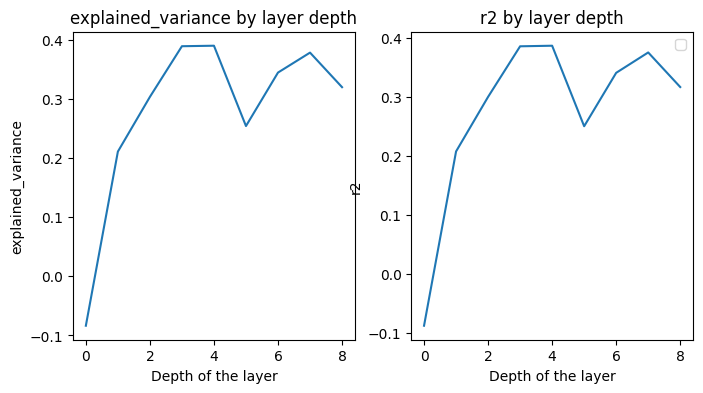

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
for ax, metric in zip(axs,("explained_variance", "r2")):
    values = [scores[key][metric] for key in densenet_shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")
plt.legend()

In [35]:
scores = analyze("densenet169/pretrained", "Ridge", densenet_shapes)

Layer conv0
Set name : train
RMSE: 0.34179357758852913
R2: 0.13538714785646283
Explained Variance: 0.13538708528246457
Set name : validation
RMSE: 0.36041946045731876
R2: 0.06678126431660104
Explained Variance: 0.0711255313812486



Layer denseblock1
Set name : train
RMSE: 0.2867632555308649
R2: 0.3764419910014654
Explained Variance: 0.37644194762180955
Set name : validation
RMSE: 0.3296807175062219
R2: 0.20284611234812522
Explained Variance: 0.20624550655886104



Layer denseblock2
Set name : train
RMSE: 0.23365661953165304
R2: 0.5679778400410882
Explained Variance: 0.567977811541518
Set name : validation
RMSE: 0.29777317656818886
R2: 0.32072203032479973
Explained Variance: 0.3238138910082232



Layer denseblock3
Set name : train
RMSE: 0.24525379076008605
R2: 0.5151854145113983
Explained Variance: 0.5151853823603871
Set name : validation
RMSE: 0.27923711318800576
R2: 0.3895656496956831
Explained Variance: 0.3925359550655488



Layer denseblock4
Set name : train
RMSE: 0.231267503536020

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.0711255313812486, 0.20624550655886104, 0.3238138910082232, 0.3925359550655488, 0.42428866858984987, 0.2855488931838962, 0.3845300058324125, 0.41241299239817797, 0.388065229682758]
[0.06678126431660104, 0.20284611234812522, 0.32072203032479973, 0.3895656496956831, 0.4217506367364367, 0.2822540211792206, 0.3814991645075243, 0.40990965319249123, 0.3848571128077206]


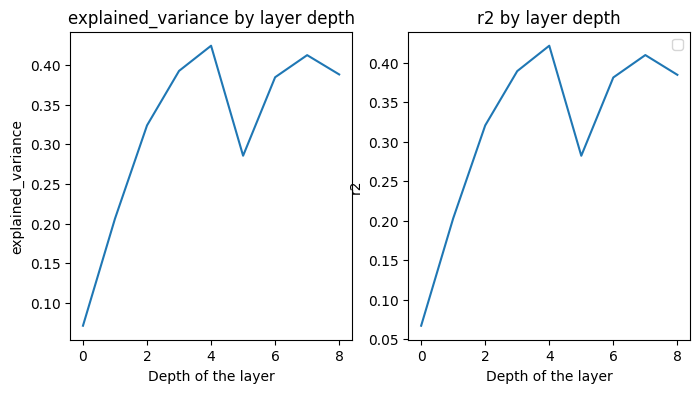

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
for ax, metric in zip(axs,("explained_variance", "r2")):
    values = [scores[key][metric] for key in densenet_shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")
plt.legend()

In [39]:
scores = analyze("densenet169/pretrained", "xgb")
fig, axs = plt.subplots(1, 2, figsize=(8,4))
for ax, metric in zip(axs,("explained_variance", "r2")):
    values = [scores[key][metric] for key in densenet_shapes.keys()]
    print(values)
    ax.plot(range(len(values)), values)
    ax.set_xlabel("Depth of the layer")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by layer depth")
plt.legend()

Layer conv0
Set name : train
RMSE: 0.05923158675432205
R2: 0.9737774450806895
Explained Variance: 0.9737774694249743
Set name : validation
RMSE: 0.3764118552207947
R2: -0.02436917206671731
Explained Variance: -0.01794315164997464



Layer denseblock1
Set name : train
RMSE: 0.0584510862827301
R2: 0.9733315445295849
Explained Variance: 0.973331562819935
Set name : validation
RMSE: 0.3535957336425781
R2: 0.08600656542751539
Explained Variance: 0.10717484390451795



Layer denseblock2
Set name : train
RMSE: 0.05545235797762871
R2: 0.9751248280441861
Explained Variance: 0.9751248476760728
Set name : validation
RMSE: 0.3402099609375
R2: 0.14480543888138997
Explained Variance: 0.16116524842523394



Layer denseblock3
Set name : train
RMSE: 0.052421778440475464
R2: 0.9773484527510958
Explained Variance: 0.9773484681333814
Set name : validation
RMSE: 0.3202861547470093
R2: 0.22389775213107435
Explained Variance: 0.2349518704272452



Layer denseblock4
Set name : train
RMSE: 0.0515127070248127
R

# Finetuning using the classifier module

In [11]:
from torchvision.transforms.v2 import AutoAugment

In [12]:
import torchvision.transforms as transforms
import torchvision


In [13]:
standard_transform =  ResNet50_Weights.IMAGENET1K_V2.transforms()

In [14]:
train_transform = torchvision.transforms.Compose([

    AutoAugment(),
    ResNet50_Weights.IMAGENET1K_V2.transforms(),
])


In [15]:
import torch.nn.functional as F
# Define your custom layer
class CustomLayer_v2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomLayer_v2, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        # Add any other layers or modifications as needed
        nn.init.kaiming_normal_(self.fc.weight)
        nn.init.zeros_(self.fc.bias) 

    def forward(self, x):
        x = self.fc(x)
        F.softmax(x,dim=-1)
        # Add any other operations in the forward pass
        return x

In [16]:
list_objects,counts = np.unique(objects_train, return_counts=True)

list_objects,counts

(array(['airplane0', 'airplane1', 'airplane2', 'airplane3', 'airplane4',
        'airplane5', 'airplane6', 'airplane7', 'apple', 'apricot', 'bear',
        'car_alfa', 'car_astra', 'car_beetle', 'car_bmw', 'car_bora',
        'car_celica', 'car_clio', 'car_z3', 'chair0', 'chair1', 'chair2',
        'chair3', 'chair4', 'chair5', 'chair6', 'chair7', 'cow', 'dog',
        'elephant', 'face0', 'face1', 'face2', 'face3', 'face4', 'face5',
        'face6', 'face7', 'gorilla', 'hedgehog', 'lioness', 'peach',
        'pear', 'raspberry', 'ship0', 'ship1', 'ship2', 'ship3', 'ship4',
        'ship5', 'ship6', 'ship7', 'strawberry', 'table0', 'table1',
        'table2', 'table3', 'table4', 'table5', 'table6', 'table7',
        'turtle', 'walnut', 'watermelon'], dtype='<U10'),
 array([41, 40, 40, 41, 41, 41, 41, 40, 41, 41, 40, 40, 41, 41, 40, 40, 41,
        41, 40, 41, 40, 40, 40, 40, 40, 41, 40, 40, 40, 40, 41, 41, 40, 41,
        41, 40, 41, 40, 40, 40, 41, 41, 40, 40, 41, 40, 40, 41, 40, 41, 

In [17]:
idx_to_cat = {}
cat_to_idx = {}
for idx, cat in enumerate(list_objects):
    idx_to_cat[idx] = cat
    cat_to_idx[cat] = idx
objects_idx_train = [cat_to_idx[i] for i in objects_train]
objects_idx_val = [cat_to_idx[i] for i in objects_val]

In [19]:
batch_size=64

In [20]:

train_dataset = CustomTensorDataset( (standard_transform(torch.tensor(stimulus_train)), 
                                     torch.tensor(objects_idx_train, dtype=torch.long)))


validation_dataset = CustomTensorDataset((standard_transform(torch.tensor(stimulus_val)),torch.tensor(objects_idx_val, dtype=torch.long)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [24]:
resnet = resnet50(pretrained=True)

in_features = resnet.fc.in_features

custom_layer = CustomLayer_v2(in_features, len(list_objects))  #

resnet.fc = custom_layer

criterion = nn.CrossEntropyLoss()
num_epochs= 200
lr = 1e-4

optimizer = NAdam(resnet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=lr, total_steps=num_epochs*len(train_loader), 
                                                            pct_start=0.1, anneal_strategy="linear", 
                                                            cycle_momentum=False, div_factor=1e2, final_div_factor=.1)

resnet = train_model(resnet, scheduler, train_loader, validation_loader,criterion, optimizer, num_epochs=num_epochs)

Epoch 60/200:  30%|███       | 60/200 [03:38<08:30,  3.65s/it, patience=19, train_loss=0.000283, val_loss=0.308]


In [25]:
resnet_layers = {
    'conv1': resnet.conv1,
    'layer1': resnet.layer1,
    'layer2': resnet.layer2,
    'layer3': resnet.layer3,
    'layer4': resnet.layer4,
    'avgpool': resnet.avgpool
}

In [26]:
shapes = {'conv1': 802816,
 'layer1': 802816,
 'layer2': 401408,
 'layer3': 200704,
 'layer4': 100352,
 'avgpool': 2048}

In [27]:
resnet.cpu();

In [28]:
for stimulus, suffix, batch_size in zip ((stimulus_train, stimulus_val), ("train", "val"), (162,32)):
    folder = "resnet50/finetuned"

    activation_files = {name: np.memmap(f"{folder}/{name}_activations_{suffix}.npy" , dtype=np.float32, mode='w+', shape=(len(stimulus),shapes[name]))
                        for name in resnet_layers.keys()}

    def hook(name, idx):
        def hook(module, input, output):
            output = output.detach().cpu().reshape(batch_size, -1).numpy()
            activation_files[name][idx*batch_size:(idx+1)*batch_size,:] = output  
            activation_files[name].flush()
        return hook

    for key,layer in resnet_layers.items():

        for idx in tqdm(range(len(stimulus)//batch_size)):
            hook_handle = layer.register_forward_hook(hook(key,idx))
            batch = stimulus[idx*batch_size:(idx+1)*batch_size]
            _ = resnet(torch.tensor(batch))
            hook_handle.remove()

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:03<00:00,  2.98it/s]


In [29]:
num_components = 1000  
device = "cuda"
folder = "resnet50/finetuned"

for key,item in tqdm(shapes.items()):
    array = torch.tensor(np.memmap(f"{folder}/{key}_activations_train.npy" , mode='r',shape=(len(stimulus_train),item), dtype=np.float32), dtype=torch.float32).to(device)

    U, S, V = torch.pca_lowrank(array, q=num_components)
    array = torch.matmul(array, V).cpu().numpy()
    np.save(f"{folder}/{key}_{num_components}PCs_train.npy", array)

    array = torch.tensor(np.memmap(f"{folder}/{key}_activations_val.npy" , mode='r',shape=(len(stimulus_val),item), dtype=np.float32), dtype=torch.float32).to(device)
    array = torch.matmul(array, V).cpu().numpy()
    np.save(f"{folder}/{key}_{num_components}PCs_val.npy", array)

100%|██████████| 6/6 [00:34<00:00,  5.73s/it]


In [35]:
scores = analyze("resnet50/finetuned", "Linear", shapes)

Layer conv1
Set name : train
RMSE: 0.2677997648715973
R2: 0.46553811727734146
Explained Variance: 0.46553815262658255
Set name : validation
RMSE: 0.37592676281929016
R2: -0.03036621857987698
Explained Variance: -0.02650852288518633



Layer layer1
Set name : train
RMSE: 0.22407479584217072
R2: 0.6063294778262553
Explained Variance: 0.606329484354882
Set name : validation
RMSE: 0.3083347976207733
R2: 0.27606158332869996
Explained Variance: 0.2803523785301617



Layer layer2
Set name : train
RMSE: 0.21506744623184204
R2: 0.6324031648654258
Explained Variance: 0.6324031881633259
Set name : validation
RMSE: 0.29926398396492004
R2: 0.309116018495022
Explained Variance: 0.3127075834643273



Layer layer3
Set name : train
RMSE: 0.1934894323348999
R2: 0.6847943273053307
Explained Variance: 0.6847943110125405
Set name : validation
RMSE: 0.2711813449859619
R2: 0.4069691382328659
Explained Variance: 0.4103246717935517



Layer layer4
Set name : train
RMSE: 0.1993751972913742
R2: 0.666600154378993

In [36]:
scores = analyze("resnet50/finetuned", "Ridge", shapes)

Layer conv1
Set name : train
RMSE: 0.31143439815393903
R2: 0.2791584142983553
Explained Variance: 0.27915836117928866
Set name : validation
RMSE: 0.35377099506777143
R2: 0.09467374810175529
Explained Variance: 0.09859527631995257



Layer layer1
Set name : train
RMSE: 0.2554066096040132
R2: 0.4957841751478561
Explained Variance: 0.495784141431634
Set name : validation
RMSE: 0.31104643953392996
R2: 0.27550446291796843
Explained Variance: 0.27961200641815553



Layer layer2
Set name : train
RMSE: 0.2641080214382928
R2: 0.46116922753440176
Explained Variance: 0.4611691901906567
Set name : validation
RMSE: 0.30959042685659455
R2: 0.282239740629351
Explained Variance: 0.28634537269119353



Layer layer3
Set name : train
RMSE: 0.22776679177828338
R2: 0.5776092963226137
Explained Variance: 0.5776092685584778
Set name : validation
RMSE: 0.27895944119967525
R2: 0.39146581086171817
Explained Variance: 0.3951153280657012



Layer layer4
Set name : train
RMSE: 0.22384111971121085
R2: 0.58784874095